#MNIST dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from copy import deepcopy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda


In [2]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 13.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 336kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.91MB/s]


In [3]:
class TimeLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TimeLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        # Standard LSTM gates
        self.W_i = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_i = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_i = nn.Parameter(torch.Tensor(hidden_size))

        self.W_f = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_f = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_f = nn.Parameter(torch.Tensor(hidden_size))

        self.W_c = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_c = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_c = nn.Parameter(torch.Tensor(hidden_size))

        self.W_o = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_o = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_o = nn.Parameter(torch.Tensor(hidden_size))

        # Time gate
        self.W_t = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_t = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_t = nn.Parameter(torch.Tensor(hidden_size))

        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x, h, c, elapsed_time):
        # Elapsed time should be normalized (batch_size, 1)
        i = torch.sigmoid(x @ self.W_i + h @ self.U_i + self.b_i)
        f = torch.sigmoid(x @ self.W_f + h @ self.U_f + self.b_f)
        g = torch.tanh(x @ self.W_c + h @ self.U_c + self.b_c)
        o = torch.sigmoid(x @ self.W_o + h @ self.U_o + self.b_o)

        # Time gate
        t = torch.sigmoid(x @ self.W_t + h @ self.U_t + elapsed_time + self.b_t)

        c_new = f * c + i * g * t  # Time gate modulates input
        h_new = o * torch.tanh(c_new)

        return h_new, c_new

class TimeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(TimeLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.cells = nn.ModuleList()
        self.cells.append(TimeLSTMCell(input_size, hidden_size))
        for _ in range(num_layers - 1):
            self.cells.append(TimeLSTMCell(hidden_size, hidden_size))

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, delta_times=None):
        # x shape: (batch_size, channels, height, width)
        x = x.squeeze(1)  # Remove channel dim (batch_size, 28, 28)
        x = x.permute(0, 2, 1)  # (batch_size, 28, 28)

        batch_size, seq_len, _ = x.size()

        if delta_times is None:
            delta_times = torch.ones(batch_size, seq_len, 1).to(device)

        # Initialize hidden states
        h = [torch.zeros(batch_size, self.hidden_size).to(device) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_size).to(device) for _ in range(self.num_layers)]

        # Process each time step
        for t in range(seq_len):
            x_t = x[:, t, :]
            elapsed_time = delta_times[:, t, :]

            for layer in range(self.num_layers):
                h[layer], c[layer] = self.cells[layer](x_t, h[layer], c[layer], elapsed_time)
                x_t = h[layer]  # Output becomes input to next layer

        out = self.fc(h[-1])
        return out

# Standard LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.squeeze(1)  # (batch_size, 28, 28)
        x = x.permute(0, 2, 1)  # (batch_size, 28, 28)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [4]:
# Hyperparameters
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
learning_rate = 0.001
num_epochs = 30
patience = 5  # For early stopping

# Initialize models
lstm_model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
time_lstm_model = TimeLSTM(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
time_lstm_optimizer = optim.Adam(time_lstm_model.parameters(), lr=learning_rate)

In [5]:
# Training function with early stopping
def train_model(model, optimizer, model_name, teacher_forcing=False):
    best_acc = 0.0
    best_model_wts = deepcopy(model.state_dict())
    epochs_no_improve = 0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            running_correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100 * running_correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / val_total
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Print epoch results
        print(f"{model_name} - Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            epochs_no_improve = 0
            print(f"New best accuracy: {best_acc:.2f}%")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve}/{patience} epochs")

            # Early stopping
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Save learning curves
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Learning Curve - Loss')
    plt.legend()
    plt.savefig(f'{model_name}_loss_curve.png')
    plt.show()

    plt.figure()
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} Learning Curve - Accuracy')
    plt.legend()
    plt.savefig(f'{model_name}_acc_curve.png')
    plt.show()

    return model, train_losses, train_accs, val_losses, val_accs


Training Standard LSTM...


Epoch 1/30: 100%|██████████| 938/938 [00:16<00:00, 58.09it/s]


Standard_LSTM - Epoch 1/30:
Train Loss: 0.4130, Train Acc: 86.71%
Val Loss: 0.1376, Val Acc: 95.87%
New best accuracy: 95.87%


Epoch 2/30: 100%|██████████| 938/938 [00:16<00:00, 58.58it/s]


Standard_LSTM - Epoch 2/30:
Train Loss: 0.1104, Train Acc: 96.75%
Val Loss: 0.0822, Val Acc: 97.46%
New best accuracy: 97.46%


Epoch 3/30: 100%|██████████| 938/938 [00:16<00:00, 57.13it/s]


Standard_LSTM - Epoch 3/30:
Train Loss: 0.0753, Train Acc: 97.75%
Val Loss: 0.0772, Val Acc: 97.75%
New best accuracy: 97.75%


Epoch 4/30: 100%|██████████| 938/938 [00:15<00:00, 60.89it/s]


Standard_LSTM - Epoch 4/30:
Train Loss: 0.0587, Train Acc: 98.24%
Val Loss: 0.0666, Val Acc: 98.14%
New best accuracy: 98.14%


Epoch 5/30: 100%|██████████| 938/938 [00:16<00:00, 57.46it/s]


Standard_LSTM - Epoch 5/30:
Train Loss: 0.0470, Train Acc: 98.56%
Val Loss: 0.0727, Val Acc: 97.96%
No improvement for 1/5 epochs


Epoch 6/30: 100%|██████████| 938/938 [00:15<00:00, 60.23it/s]


Standard_LSTM - Epoch 6/30:
Train Loss: 0.0400, Train Acc: 98.75%
Val Loss: 0.0579, Val Acc: 98.29%
New best accuracy: 98.29%


Epoch 7/30: 100%|██████████| 938/938 [00:15<00:00, 60.27it/s]


Standard_LSTM - Epoch 7/30:
Train Loss: 0.0332, Train Acc: 98.98%
Val Loss: 0.0539, Val Acc: 98.49%
New best accuracy: 98.49%


Epoch 8/30: 100%|██████████| 938/938 [00:15<00:00, 60.39it/s]


Standard_LSTM - Epoch 8/30:
Train Loss: 0.0321, Train Acc: 98.99%
Val Loss: 0.0576, Val Acc: 98.34%
No improvement for 1/5 epochs


Epoch 9/30: 100%|██████████| 938/938 [00:15<00:00, 60.36it/s]


Standard_LSTM - Epoch 9/30:
Train Loss: 0.0266, Train Acc: 99.17%
Val Loss: 0.0490, Val Acc: 98.57%
New best accuracy: 98.57%


Epoch 10/30: 100%|██████████| 938/938 [00:15<00:00, 60.10it/s]


Standard_LSTM - Epoch 10/30:
Train Loss: 0.0214, Train Acc: 99.36%
Val Loss: 0.0502, Val Acc: 98.59%
New best accuracy: 98.59%


Epoch 11/30: 100%|██████████| 938/938 [00:15<00:00, 60.29it/s]


Standard_LSTM - Epoch 11/30:
Train Loss: 0.0190, Train Acc: 99.38%
Val Loss: 0.0593, Val Acc: 98.43%
No improvement for 1/5 epochs


Epoch 12/30: 100%|██████████| 938/938 [00:15<00:00, 60.31it/s]


Standard_LSTM - Epoch 12/30:
Train Loss: 0.0215, Train Acc: 99.32%
Val Loss: 0.0455, Val Acc: 98.71%
New best accuracy: 98.71%


Epoch 13/30: 100%|██████████| 938/938 [00:15<00:00, 61.06it/s]


Standard_LSTM - Epoch 13/30:
Train Loss: 0.0172, Train Acc: 99.48%
Val Loss: 0.0560, Val Acc: 98.62%
No improvement for 1/5 epochs


Epoch 14/30: 100%|██████████| 938/938 [00:15<00:00, 59.49it/s]


Standard_LSTM - Epoch 14/30:
Train Loss: 0.0153, Train Acc: 99.50%
Val Loss: 0.0470, Val Acc: 98.77%
New best accuracy: 98.77%


Epoch 15/30: 100%|██████████| 938/938 [00:15<00:00, 61.21it/s]


Standard_LSTM - Epoch 15/30:
Train Loss: 0.0162, Train Acc: 99.50%
Val Loss: 0.0503, Val Acc: 98.72%
No improvement for 1/5 epochs


Epoch 16/30: 100%|██████████| 938/938 [00:15<00:00, 58.92it/s]


Standard_LSTM - Epoch 16/30:
Train Loss: 0.0124, Train Acc: 99.59%
Val Loss: 0.0551, Val Acc: 98.66%
No improvement for 2/5 epochs


Epoch 17/30: 100%|██████████| 938/938 [00:15<00:00, 61.59it/s]


Standard_LSTM - Epoch 17/30:
Train Loss: 0.0097, Train Acc: 99.66%
Val Loss: 0.0522, Val Acc: 98.86%
New best accuracy: 98.86%


Epoch 18/30: 100%|██████████| 938/938 [00:15<00:00, 58.64it/s]


Standard_LSTM - Epoch 18/30:
Train Loss: 0.0134, Train Acc: 99.56%
Val Loss: 0.0577, Val Acc: 98.62%
No improvement for 1/5 epochs


Epoch 19/30: 100%|██████████| 938/938 [00:15<00:00, 60.90it/s]


Standard_LSTM - Epoch 19/30:
Train Loss: 0.0115, Train Acc: 99.62%
Val Loss: 0.0481, Val Acc: 98.77%
No improvement for 2/5 epochs


Epoch 20/30: 100%|██████████| 938/938 [00:16<00:00, 56.35it/s]


Standard_LSTM - Epoch 20/30:
Train Loss: 0.0088, Train Acc: 99.72%
Val Loss: 0.0494, Val Acc: 98.84%
No improvement for 3/5 epochs


Epoch 21/30: 100%|██████████| 938/938 [00:15<00:00, 60.40it/s]


Standard_LSTM - Epoch 21/30:
Train Loss: 0.0079, Train Acc: 99.73%
Val Loss: 0.0537, Val Acc: 98.72%
No improvement for 4/5 epochs


Epoch 22/30: 100%|██████████| 938/938 [00:15<00:00, 60.24it/s]


Standard_LSTM - Epoch 22/30:
Train Loss: 0.0079, Train Acc: 99.75%
Val Loss: 0.0536, Val Acc: 98.75%
No improvement for 5/5 epochs
Early stopping at epoch 22


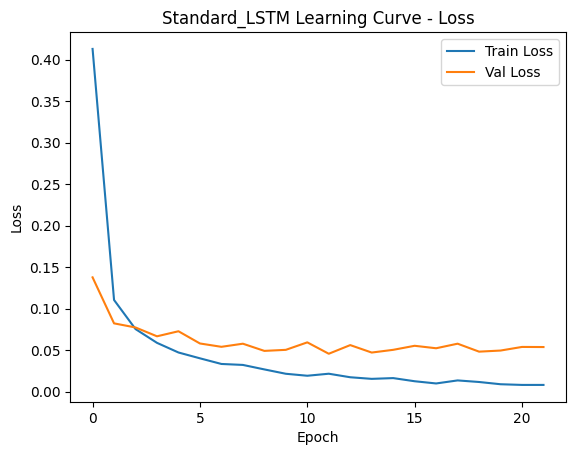

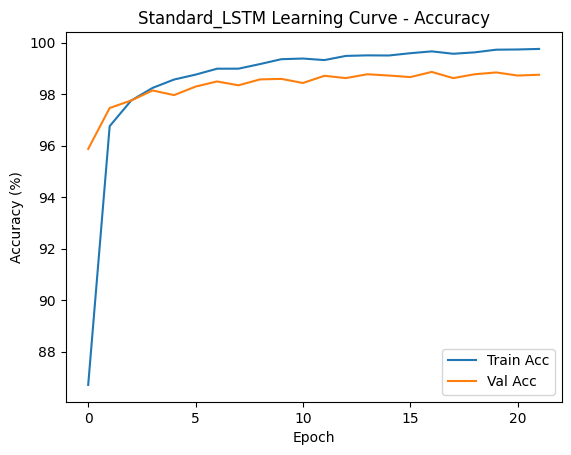


Training Time-LSTM...


Epoch 1/30: 100%|██████████| 938/938 [01:38<00:00,  9.52it/s]


Time_LSTM - Epoch 1/30:
Train Loss: 0.4436, Train Acc: 85.56%
Val Loss: 0.1585, Val Acc: 95.11%
New best accuracy: 95.11%


Epoch 2/30: 100%|██████████| 938/938 [01:40<00:00,  9.32it/s]


Time_LSTM - Epoch 2/30:
Train Loss: 0.1106, Train Acc: 96.77%
Val Loss: 0.0836, Val Acc: 97.52%
New best accuracy: 97.52%


Epoch 3/30: 100%|██████████| 938/938 [01:38<00:00,  9.53it/s]


Time_LSTM - Epoch 3/30:
Train Loss: 0.0737, Train Acc: 97.82%
Val Loss: 0.0787, Val Acc: 97.64%
New best accuracy: 97.64%


Epoch 4/30: 100%|██████████| 938/938 [01:38<00:00,  9.53it/s]


Time_LSTM - Epoch 4/30:
Train Loss: 0.0563, Train Acc: 98.27%
Val Loss: 0.0795, Val Acc: 97.42%
No improvement for 1/5 epochs


Epoch 5/30: 100%|██████████| 938/938 [01:39<00:00,  9.43it/s]


Time_LSTM - Epoch 5/30:
Train Loss: 0.0464, Train Acc: 98.61%
Val Loss: 0.0528, Val Acc: 98.42%
New best accuracy: 98.42%


Epoch 6/30: 100%|██████████| 938/938 [01:37<00:00,  9.60it/s]


Time_LSTM - Epoch 6/30:
Train Loss: 0.0371, Train Acc: 98.89%
Val Loss: 0.0538, Val Acc: 98.34%
No improvement for 1/5 epochs


Epoch 7/30: 100%|██████████| 938/938 [01:38<00:00,  9.56it/s]


Time_LSTM - Epoch 7/30:
Train Loss: 0.0345, Train Acc: 98.94%
Val Loss: 0.0502, Val Acc: 98.64%
New best accuracy: 98.64%


Epoch 8/30: 100%|██████████| 938/938 [01:39<00:00,  9.41it/s]


Time_LSTM - Epoch 8/30:
Train Loss: 0.0281, Train Acc: 99.09%
Val Loss: 0.0440, Val Acc: 98.82%
New best accuracy: 98.82%


Epoch 9/30: 100%|██████████| 938/938 [01:44<00:00,  8.95it/s]


Time_LSTM - Epoch 9/30:
Train Loss: 0.0247, Train Acc: 99.23%
Val Loss: 0.0479, Val Acc: 98.60%
No improvement for 1/5 epochs


Epoch 10/30: 100%|██████████| 938/938 [01:47<00:00,  8.73it/s]


Time_LSTM - Epoch 10/30:
Train Loss: 0.0234, Train Acc: 99.28%
Val Loss: 0.0440, Val Acc: 98.69%
No improvement for 2/5 epochs


Epoch 11/30: 100%|██████████| 938/938 [01:44<00:00,  9.00it/s]


Time_LSTM - Epoch 11/30:
Train Loss: 0.0181, Train Acc: 99.41%
Val Loss: 0.0459, Val Acc: 98.63%
No improvement for 3/5 epochs


Epoch 12/30: 100%|██████████| 938/938 [01:40<00:00,  9.31it/s]


Time_LSTM - Epoch 12/30:
Train Loss: 0.0169, Train Acc: 99.48%
Val Loss: 0.0477, Val Acc: 98.78%
No improvement for 4/5 epochs


Epoch 13/30: 100%|██████████| 938/938 [01:41<00:00,  9.25it/s]


Time_LSTM - Epoch 13/30:
Train Loss: 0.0155, Train Acc: 99.48%
Val Loss: 0.0575, Val Acc: 98.50%
No improvement for 5/5 epochs
Early stopping at epoch 13


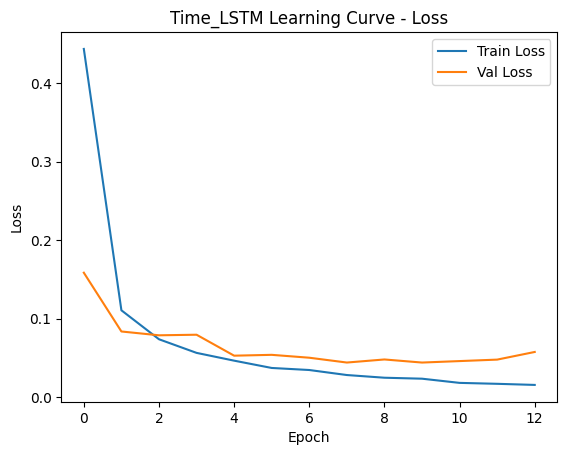

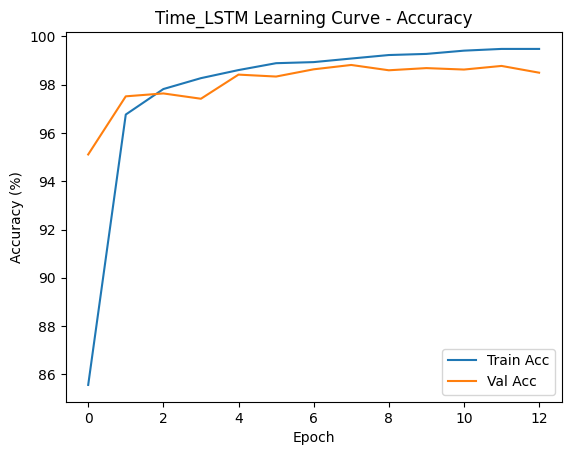

In [6]:
# Train both models
print("Training Standard LSTM...")
lstm_model, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc = train_model(
    lstm_model, lstm_optimizer, "Standard_LSTM")

print("\nTraining Time-LSTM...")
time_lstm_model, time_train_loss, time_train_acc, time_val_loss, time_val_acc = train_model(
    time_lstm_model, time_lstm_optimizer, "Time_LSTM")

In [7]:
# Final evaluation
def evaluate_model(model, model_name):
    model.eval()
    correct = 0
    total = 0
    inference_times = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Measure inference time
            start_time = time.time()
            outputs = model(images)
            inference_times.append((time.time() - start_time) * 1000)  # ms

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_latency = np.mean(inference_times)
    accuracy = 100 * correct / total
    print(f"{model_name} Test Accuracy: {accuracy:.2f}%")
    print(f"Average Inference Latency: {avg_latency:.2f} ms")
    return accuracy, avg_latency

In [8]:
print("\nFinal Evaluation:")
lstm_acc, lstm_latency = evaluate_model(lstm_model, "Standard LSTM")
time_lstm_acc, time_lstm_latency = evaluate_model(time_lstm_model, "Time-LSTM")

# Comparative analysis
print("\nComparative Analysis:")
print("Standard LSTM:")
print(f"- Parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")
print(f"- Val Accuracy: {max(lstm_val_acc):.2f}%")
print(f"- Inference Latency: {lstm_latency:.2f} ms")

print("\nTime-LSTM:")
print(f"- Parameters: {sum(p.numel() for p in time_lstm_model.parameters()):,}")
print(f"- Val Accuracy: {max(time_val_acc):.2f}%")
print(f"- Inference Latency: {time_lstm_latency:.2f} ms")

# Save results
print("\nResults:")
print(f"LSTM | {sum(p.numel() for p in lstm_model.parameters())/1e6:.1f}M | - | {min(lstm_val_loss):.4f} | {lstm_latency:.2f}")
print(f"Time-LSTM | {sum(p.numel() for p in time_lstm_model.parameters())/1e6:.1f}M | - | {min(time_val_loss):.4f} | {time_lstm_latency:.2f}")


Final Evaluation:
Standard LSTM Test Accuracy: 98.86%
Average Inference Latency: 0.48 ms
Time-LSTM Test Accuracy: 98.82%
Average Inference Latency: 27.21 ms

Comparative Analysis:
Standard LSTM:
- Parameters: 214,282
- Val Accuracy: 98.86%
- Inference Latency: 0.48 ms

Time-LSTM:
- Parameters: 266,250
- Val Accuracy: 98.82%
- Inference Latency: 27.21 ms

Results:
LSTM | 0.2M | - | 0.0455 | 0.48
Time-LSTM | 0.3M | - | 0.0440 | 27.21


#CIFAR-10 dataset

In [9]:
# Transformations for CIFAR-10 (3 channels, 32x32 images)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 3 channels
])

# Load CIFAR-10 datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:05<00:00, 30.0MB/s]


In [12]:
# Time-LSTM implementation (modified for CIFAR-10)
class TimeLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TimeLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        # Standard LSTM gates
        self.W_i = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_i = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_i = nn.Parameter(torch.Tensor(hidden_size))

        self.W_f = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_f = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_f = nn.Parameter(torch.Tensor(hidden_size))

        self.W_c = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_c = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_c = nn.Parameter(torch.Tensor(hidden_size))

        self.W_o = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_o = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_o = nn.Parameter(torch.Tensor(hidden_size))

        # Time gate
        self.W_t = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_t = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_t = nn.Parameter(torch.Tensor(hidden_size))

        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x, h, c, elapsed_time):
        # Elapsed time should be normalized (batch_size, 1)
        i = torch.sigmoid(x @ self.W_i + h @ self.U_i + self.b_i)
        f = torch.sigmoid(x @ self.W_f + h @ self.U_f + self.b_f)
        g = torch.tanh(x @ self.W_c + h @ self.U_c + self.b_c)
        o = torch.sigmoid(x @ self.W_o + h @ self.U_o + self.b_o)

        # Time gate
        t = torch.sigmoid(x @ self.W_t + h @ self.U_t + elapsed_time + self.b_t)

        c_new = f * c + i * g * t  # Time gate modulates input
        h_new = o * torch.tanh(c_new)

        return h_new, c_new

class TimeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(TimeLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Initial conv layer to process CIFAR-10 images
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.cells = nn.ModuleList()
        self.cells.append(TimeLSTMCell(input_size//4 * 64, hidden_size))  # Adjusted for conv output
        for _ in range(num_layers - 1):
            self.cells.append(TimeLSTMCell(hidden_size, hidden_size))

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, delta_times=None):
        # Apply convolutional layers first
        x = self.conv(x)
        batch_size, channels, height, width = x.size()
        x = x.reshape(batch_size, channels * height, width)  # Combine channels and height

        seq_len = width  # Now our sequence length is the width after conv

        if delta_times is None:
            delta_times = torch.ones(batch_size, seq_len, 1).to(device)

        # Initialize hidden states
        h = [torch.zeros(batch_size, self.hidden_size).to(device) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_size).to(device) for _ in range(self.num_layers)]

        # Process each time step
        for t in range(seq_len):
            x_t = x[:, :, t]
            elapsed_time = delta_times[:, t, :]

            for layer in range(self.num_layers):
                h[layer], c[layer] = self.cells[layer](x_t, h[layer], c[layer], elapsed_time)
                x_t = h[layer]  # Output becomes input to next layer

        out = self.fc(h[-1])
        return out

# Standard LSTM Model (modified for CIFAR-10)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Initial conv layer to process CIFAR-10 images
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.lstm = nn.LSTM(input_size//4 * 64, hidden_size, num_layers, batch_first=True)  # Adjusted for conv output
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Apply convolutional layers first
        x = self.conv(x)
        batch_size, channels, height, width = x.size()
        x = x.reshape(batch_size, channels * height, width)  # Combine channels and height
        x = x.permute(0, 2, 1)  # (batch_size, seq_len, features)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [13]:
# Hyperparameters (adjusted for CIFAR-10)
input_size = 32  # CIFAR-10 images are 32x32
hidden_size = 256  # Increased hidden size for more complex data
num_layers = 2
num_classes = 10  # CIFAR-10 has 10 classes
learning_rate = 0.001
num_epochs = 30
patience = 5  # For early stopping

# Initialize models
lstm_model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
time_lstm_model = TimeLSTM(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
time_lstm_optimizer = optim.Adam(time_lstm_model.parameters(), lr=learning_rate)

In [14]:
# Training function with early stopping
def train_model(model, optimizer, model_name):
    best_acc = 0.0
    best_model_wts = deepcopy(model.state_dict())
    epochs_no_improve = 0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            running_correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100 * running_correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / val_total
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Print epoch results
        print(f"{model_name} - Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            epochs_no_improve = 0
            print(f"New best accuracy: {best_acc:.2f}%")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve}/{patience} epochs")

            # Early stopping
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Save learning curves
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Learning Curve - Loss')
    plt.legend()
    plt.savefig(f'{model_name}_loss_curve.png')
    plt.show()

    plt.figure()
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} Learning Curve - Accuracy')
    plt.legend()
    plt.savefig(f'{model_name}_acc_curve.png')
    plt.show() #

    return model, train_losses, train_accs, val_losses, val_accs

Training Standard LSTM...


Epoch 1/30: 100%|██████████| 782/782 [00:17<00:00, 44.77it/s]


Standard_LSTM - Epoch 1/30:
Train Loss: 1.4859, Train Acc: 45.15%
Val Loss: 1.1842, Val Acc: 57.44%
New best accuracy: 57.44%


Epoch 2/30: 100%|██████████| 782/782 [00:18<00:00, 43.03it/s]


Standard_LSTM - Epoch 2/30:
Train Loss: 1.0437, Train Acc: 62.75%
Val Loss: 0.9714, Val Acc: 65.11%
New best accuracy: 65.11%


Epoch 3/30: 100%|██████████| 782/782 [00:17<00:00, 45.41it/s]


Standard_LSTM - Epoch 3/30:
Train Loss: 0.8305, Train Acc: 70.63%
Val Loss: 0.8472, Val Acc: 70.75%
New best accuracy: 70.75%


Epoch 4/30: 100%|██████████| 782/782 [00:17<00:00, 45.92it/s]


Standard_LSTM - Epoch 4/30:
Train Loss: 0.6747, Train Acc: 76.29%
Val Loss: 0.7513, Val Acc: 73.52%
New best accuracy: 73.52%


Epoch 5/30: 100%|██████████| 782/782 [00:17<00:00, 44.55it/s]


Standard_LSTM - Epoch 5/30:
Train Loss: 0.5349, Train Acc: 81.44%
Val Loss: 0.7429, Val Acc: 75.02%
New best accuracy: 75.02%


Epoch 6/30: 100%|██████████| 782/782 [00:17<00:00, 45.53it/s]


Standard_LSTM - Epoch 6/30:
Train Loss: 0.4101, Train Acc: 85.71%
Val Loss: 0.7882, Val Acc: 74.58%
No improvement for 1/5 epochs


Epoch 7/30: 100%|██████████| 782/782 [00:17<00:00, 45.59it/s]


Standard_LSTM - Epoch 7/30:
Train Loss: 0.3015, Train Acc: 89.51%
Val Loss: 0.7936, Val Acc: 76.02%
New best accuracy: 76.02%


Epoch 8/30: 100%|██████████| 782/782 [00:18<00:00, 41.87it/s]


Standard_LSTM - Epoch 8/30:
Train Loss: 0.2082, Train Acc: 92.91%
Val Loss: 0.8927, Val Acc: 75.52%
No improvement for 1/5 epochs


Epoch 9/30: 100%|██████████| 782/782 [00:17<00:00, 45.88it/s]


Standard_LSTM - Epoch 9/30:
Train Loss: 0.1514, Train Acc: 94.78%
Val Loss: 0.9776, Val Acc: 75.67%
No improvement for 2/5 epochs


Epoch 10/30: 100%|██████████| 782/782 [00:17<00:00, 45.50it/s]


Standard_LSTM - Epoch 10/30:
Train Loss: 0.1087, Train Acc: 96.36%
Val Loss: 1.0434, Val Acc: 75.56%
No improvement for 3/5 epochs


Epoch 11/30: 100%|██████████| 782/782 [00:17<00:00, 44.18it/s]


Standard_LSTM - Epoch 11/30:
Train Loss: 0.0856, Train Acc: 97.13%
Val Loss: 1.1244, Val Acc: 74.21%
No improvement for 4/5 epochs


Epoch 12/30: 100%|██████████| 782/782 [00:17<00:00, 46.00it/s]


Standard_LSTM - Epoch 12/30:
Train Loss: 0.0817, Train Acc: 97.18%
Val Loss: 1.2114, Val Acc: 74.44%
No improvement for 5/5 epochs
Early stopping at epoch 12


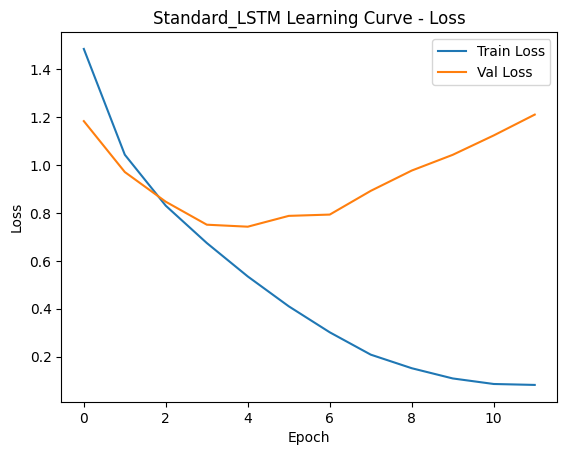

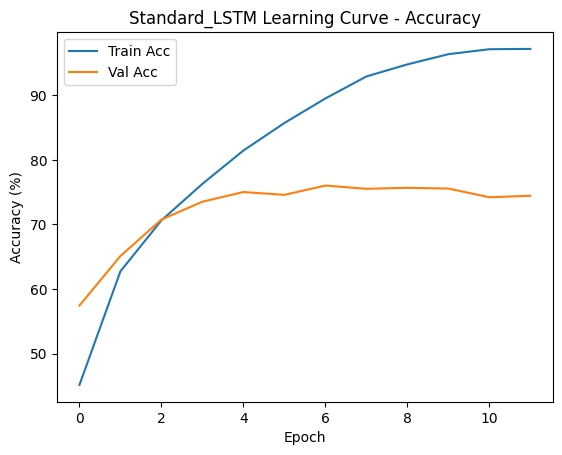


Training Time-LSTM...


Epoch 1/30: 100%|██████████| 782/782 [00:38<00:00, 20.15it/s]


Time_LSTM - Epoch 1/30:
Train Loss: 1.5001, Train Acc: 44.92%
Val Loss: 1.1978, Val Acc: 56.90%
New best accuracy: 56.90%


Epoch 2/30: 100%|██████████| 782/782 [00:38<00:00, 20.27it/s]


Time_LSTM - Epoch 2/30:
Train Loss: 1.0804, Train Acc: 61.33%
Val Loss: 0.9965, Val Acc: 64.72%
New best accuracy: 64.72%


Epoch 3/30: 100%|██████████| 782/782 [00:38<00:00, 20.21it/s]


Time_LSTM - Epoch 3/30:
Train Loss: 0.8669, Train Acc: 69.28%
Val Loss: 0.8505, Val Acc: 70.39%
New best accuracy: 70.39%


Epoch 4/30: 100%|██████████| 782/782 [00:39<00:00, 19.91it/s]


Time_LSTM - Epoch 4/30:
Train Loss: 0.7191, Train Acc: 74.51%
Val Loss: 0.8167, Val Acc: 71.72%
New best accuracy: 71.72%


Epoch 5/30: 100%|██████████| 782/782 [00:38<00:00, 20.14it/s]


Time_LSTM - Epoch 5/30:
Train Loss: 0.5815, Train Acc: 79.39%
Val Loss: 0.7730, Val Acc: 74.04%
New best accuracy: 74.04%


Epoch 6/30: 100%|██████████| 782/782 [00:39<00:00, 20.05it/s]


Time_LSTM - Epoch 6/30:
Train Loss: 0.4608, Train Acc: 83.65%
Val Loss: 0.7602, Val Acc: 75.20%
New best accuracy: 75.20%


Epoch 7/30: 100%|██████████| 782/782 [00:38<00:00, 20.18it/s]


Time_LSTM - Epoch 7/30:
Train Loss: 0.3427, Train Acc: 88.01%
Val Loss: 0.8579, Val Acc: 73.94%
No improvement for 1/5 epochs


Epoch 8/30: 100%|██████████| 782/782 [00:38<00:00, 20.30it/s]


Time_LSTM - Epoch 8/30:
Train Loss: 0.2472, Train Acc: 91.34%
Val Loss: 0.8960, Val Acc: 75.00%
No improvement for 2/5 epochs


Epoch 9/30: 100%|██████████| 782/782 [00:38<00:00, 20.28it/s]


Time_LSTM - Epoch 9/30:
Train Loss: 0.1679, Train Acc: 94.22%
Val Loss: 0.9873, Val Acc: 73.84%
No improvement for 3/5 epochs


Epoch 10/30: 100%|██████████| 782/782 [00:39<00:00, 19.77it/s]


Time_LSTM - Epoch 10/30:
Train Loss: 0.1204, Train Acc: 95.92%
Val Loss: 1.1156, Val Acc: 74.65%
No improvement for 4/5 epochs


Epoch 11/30: 100%|██████████| 782/782 [00:38<00:00, 20.21it/s]


Time_LSTM - Epoch 11/30:
Train Loss: 0.1038, Train Acc: 96.43%
Val Loss: 1.1317, Val Acc: 74.59%
No improvement for 5/5 epochs
Early stopping at epoch 11


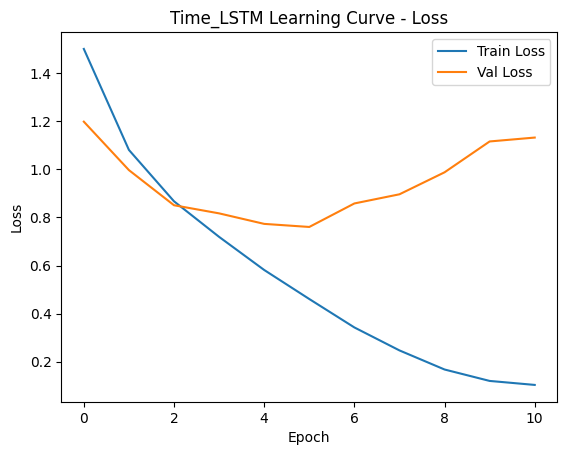

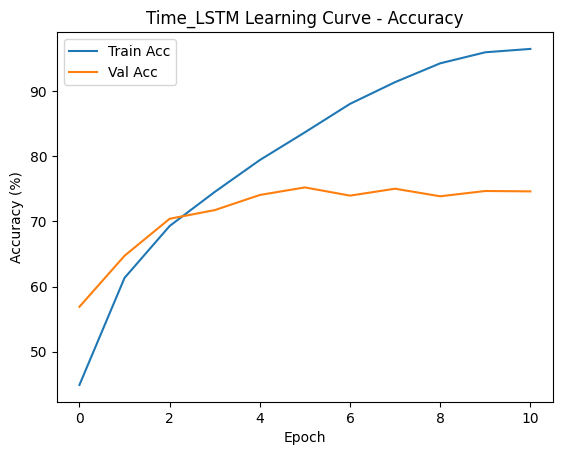

In [15]:
# Train both models
print("Training Standard LSTM...")
lstm_model, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc = train_model(
    lstm_model, lstm_optimizer, "Standard_LSTM")

print("\nTraining Time-LSTM...")
time_lstm_model, time_train_loss, time_train_acc, time_val_loss, time_val_acc = train_model(
    time_lstm_model, time_lstm_optimizer, "Time_LSTM")

In [16]:
print("\nFinal Evaluation:")
lstm_acc, lstm_latency = evaluate_model(lstm_model, "Standard LSTM")
time_lstm_acc, time_lstm_latency = evaluate_model(time_lstm_model, "Time-LSTM")

# Comparative analysis
print("\nComparative Analysis:")
print("Standard LSTM:")
print(f"- Parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")
print(f"- Val Accuracy: {max(lstm_val_acc):.2f}%")
print(f"- Inference Latency: {lstm_latency:.2f} ms")

print("\nTime-LSTM:")
print(f"- Parameters: {sum(p.numel() for p in time_lstm_model.parameters()):,}")
print(f"- Val Accuracy: {max(time_val_acc):.2f}%")
print(f"- Inference Latency: {time_lstm_latency:.2f} ms")

# Save results
print("\nResults:")
print(f"LSTM | {sum(p.numel() for p in lstm_model.parameters())/1e6:.1f}M | - | {min(lstm_val_loss):.4f} | {lstm_latency:.2f}")
print(f"Time-LSTM | {sum(p.numel() for p in time_lstm_model.parameters())/1e6:.1f}M | - | {min(time_val_loss):.4f} | {time_lstm_latency:.2f}")


Final Evaluation:
Standard LSTM Test Accuracy: 76.02%
Average Inference Latency: 1.57 ms
Time-LSTM Test Accuracy: 75.20%
Average Inference Latency: 9.46 ms

Comparative Analysis:
Standard LSTM:
- Parameters: 1,336,778
- Val Accuracy: 76.02%
- Inference Latency: 1.57 ms

Time-LSTM:
- Parameters: 1,662,922
- Val Accuracy: 75.20%
- Inference Latency: 9.46 ms

Results:
LSTM | 1.3M | - | 0.7429 | 1.57
Time-LSTM | 1.7M | - | 0.7602 | 9.46


# PhysioNet dataset

In [18]:
# download_physionet.py
from utils import PhysioNet
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download and process the dataset
root_dir = './physionet_data'  # Directory where data will be stored
train_dataset = PhysioNet(root=root_dir, train=True, download=True, quantization=0.1, device=device)
test_dataset = PhysioNet(root=root_dir, train=False, download=True, quantization=0.1, device=device)

In [19]:
# physionet_lstm.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from copy import deepcopy
from utils import PhysioNet, get_data_min_max, variable_time_collate_fn

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda


In [20]:
# Load PhysioNet datasets
root_dir = './physionet_data'
train_dataset = PhysioNet(root=root_dir, train=True, download=False, quantization=0.1, device=device)
test_dataset = PhysioNet(root=root_dir, train=False, download=False, quantization=0.1, device=device)

# Compute min and max values for normalization
data_min, data_max = get_data_min_max(train_dataset)

# Create DataLoaders with normalization parameters
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda batch: variable_time_collate_fn(
        batch,
        device=device,
        data_type="train",
        data_min=data_min,
        data_max=data_max
    )
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda batch: variable_time_collate_fn(
        batch,
        device=device,
        data_type="test",
        data_min=data_min,
        data_max=data_max
    )
)

In [21]:
# LSTM Model for PhysioNet
class PhysioNetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(PhysioNetLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer for static features (age, gender, etc.)
        self.embedding = nn.Linear(4, hidden_size)

        # LSTM for time series data
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Output layers
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, static_features=None):
        # x shape: (batch_size, seq_len, input_size)
        # static_features: (batch_size, 4) - Age, Gender, Height, ICUType

        # Process time series data
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        temporal_out, _ = self.lstm(x, (h0, c0))
        temporal_out = temporal_out[:, -1, :]  # Take last time step

        # Process static features if available
        if static_features is not None:
            static_out = self.embedding(static_features)
            combined = torch.cat([temporal_out, static_out], dim=1)
        else:
            combined = temporal_out

        out = self.dropout(combined)
        out = self.fc(out)
        return out

In [22]:
num_epochs = 30
patience = 10
criterion = nn.BCEWithLogitsLoss()

In [23]:
def train_model(model, optimizer, model_name):
    best_acc = 0.0
    best_model_wts = deepcopy(model.state_dict())
    epochs_no_improve = 0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0

        # Training loop
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            observed_data = batch["observed_data"].to(device)
            observed_mask = batch["observed_mask"].to(device)
            labels = batch["labels"].to(device).float()  # Ensure labels are float

            # Get static features (first 4 features are static)
            static_features = observed_data[:, 0, :4]

            # Forward pass
            outputs = model(observed_data, static_features)

            # Squeeze the outputs if needed (remove extra dimensions)
            outputs = outputs.squeeze(-1)  # This changes [32,1] to [32]

            # Ensure labels match outputs shape
            labels = labels.squeeze(-1)  # This changes [32,1] to [32]

            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * observed_data.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            running_correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100 * running_correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch in test_loader:
                observed_data = batch["observed_data"].to(device)
                observed_mask = batch["observed_mask"].to(device)
                labels = batch["labels"].to(device).float()
                static_features = observed_data[:, 0, :4]

                outputs = model(observed_data, static_features)
                outputs = outputs.squeeze(-1)
                labels = labels.squeeze(-1)

                loss = criterion(outputs, labels)

                val_loss += loss.item() * observed_data.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / val_total
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Print epoch results
        print(f"{model_name} - Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            epochs_no_improve = 0
            print(f"New best accuracy: {best_acc:.2f}%")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve}/{patience} epochs")

            # Early stopping
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Save learning curves
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Learning Curve - Loss')
    plt.legend()
    plt.savefig(f'{model_name}_loss_curve.png')
    plt.show()

    plt.figure()
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} Learning Curve - Accuracy')
    plt.legend()
    plt.savefig(f'{model_name}_acc_curve.png')
    plt.show()

    return model, train_losses, train_accs, val_losses, val_accs

Training PhysioNet LSTM...


Epoch 1/30: 100%|██████████| 125/125 [00:02<00:00, 52.26it/s]


PhysioNet_LSTM - Epoch 1/30:
Train Loss: 0.4259, Train Acc: 84.83%
Val Loss: 0.4098, Val Acc: 85.80%
New best accuracy: 85.80%


Epoch 2/30: 100%|██████████| 125/125 [00:01<00:00, 66.91it/s]


PhysioNet_LSTM - Epoch 2/30:
Train Loss: 0.4098, Train Acc: 86.15%
Val Loss: 0.4103, Val Acc: 85.80%
No improvement for 1/10 epochs


Epoch 3/30: 100%|██████████| 125/125 [00:01<00:00, 66.78it/s]


PhysioNet_LSTM - Epoch 3/30:
Train Loss: 0.4006, Train Acc: 86.15%
Val Loss: 0.3961, Val Acc: 85.80%
No improvement for 2/10 epochs


Epoch 4/30: 100%|██████████| 125/125 [00:01<00:00, 65.92it/s]


PhysioNet_LSTM - Epoch 4/30:
Train Loss: 0.3920, Train Acc: 86.15%
Val Loss: 0.3944, Val Acc: 85.80%
No improvement for 3/10 epochs


Epoch 5/30: 100%|██████████| 125/125 [00:01<00:00, 64.33it/s]


PhysioNet_LSTM - Epoch 5/30:
Train Loss: 0.3865, Train Acc: 86.15%
Val Loss: 0.3985, Val Acc: 85.80%
No improvement for 4/10 epochs


Epoch 6/30: 100%|██████████| 125/125 [00:01<00:00, 65.51it/s]


PhysioNet_LSTM - Epoch 6/30:
Train Loss: 0.3849, Train Acc: 86.15%
Val Loss: 0.3817, Val Acc: 85.80%
No improvement for 5/10 epochs


Epoch 7/30: 100%|██████████| 125/125 [00:01<00:00, 65.60it/s]


PhysioNet_LSTM - Epoch 7/30:
Train Loss: 0.3850, Train Acc: 86.17%
Val Loss: 0.3820, Val Acc: 85.80%
No improvement for 6/10 epochs


Epoch 8/30: 100%|██████████| 125/125 [00:01<00:00, 64.98it/s]


PhysioNet_LSTM - Epoch 8/30:
Train Loss: 0.3860, Train Acc: 86.08%
Val Loss: 0.3846, Val Acc: 85.83%
New best accuracy: 85.83%


Epoch 9/30: 100%|██████████| 125/125 [00:01<00:00, 63.26it/s]


PhysioNet_LSTM - Epoch 9/30:
Train Loss: 0.3787, Train Acc: 86.10%
Val Loss: 0.3805, Val Acc: 85.80%
No improvement for 1/10 epochs


Epoch 10/30: 100%|██████████| 125/125 [00:01<00:00, 65.10it/s]


PhysioNet_LSTM - Epoch 10/30:
Train Loss: 0.3755, Train Acc: 86.05%
Val Loss: 0.3798, Val Acc: 85.78%
No improvement for 2/10 epochs


Epoch 11/30: 100%|██████████| 125/125 [00:01<00:00, 65.44it/s]


PhysioNet_LSTM - Epoch 11/30:
Train Loss: 0.3742, Train Acc: 86.08%
Val Loss: 0.3690, Val Acc: 85.83%
No improvement for 3/10 epochs


Epoch 12/30: 100%|██████████| 125/125 [00:01<00:00, 64.97it/s]


PhysioNet_LSTM - Epoch 12/30:
Train Loss: 0.3800, Train Acc: 85.95%
Val Loss: 0.3817, Val Acc: 85.80%
No improvement for 4/10 epochs


Epoch 13/30: 100%|██████████| 125/125 [00:02<00:00, 62.22it/s]


PhysioNet_LSTM - Epoch 13/30:
Train Loss: 0.3827, Train Acc: 86.10%
Val Loss: 0.3930, Val Acc: 85.75%
No improvement for 5/10 epochs


Epoch 14/30: 100%|██████████| 125/125 [00:01<00:00, 64.96it/s]


PhysioNet_LSTM - Epoch 14/30:
Train Loss: 0.3770, Train Acc: 86.15%
Val Loss: 0.4004, Val Acc: 85.80%
No improvement for 6/10 epochs


Epoch 15/30: 100%|██████████| 125/125 [00:01<00:00, 64.62it/s]


PhysioNet_LSTM - Epoch 15/30:
Train Loss: 0.3829, Train Acc: 86.22%
Val Loss: 0.3997, Val Acc: 85.80%
No improvement for 7/10 epochs


Epoch 16/30: 100%|██████████| 125/125 [00:01<00:00, 63.16it/s]


PhysioNet_LSTM - Epoch 16/30:
Train Loss: 0.3959, Train Acc: 86.15%
Val Loss: 0.3976, Val Acc: 85.80%
No improvement for 8/10 epochs


Epoch 17/30: 100%|██████████| 125/125 [00:02<00:00, 62.10it/s]


PhysioNet_LSTM - Epoch 17/30:
Train Loss: 0.3937, Train Acc: 86.15%
Val Loss: 0.3952, Val Acc: 85.80%
No improvement for 9/10 epochs


Epoch 18/30: 100%|██████████| 125/125 [00:01<00:00, 64.22it/s]


PhysioNet_LSTM - Epoch 18/30:
Train Loss: 0.3937, Train Acc: 86.15%
Val Loss: 0.3990, Val Acc: 85.80%
No improvement for 10/10 epochs
Early stopping at epoch 18


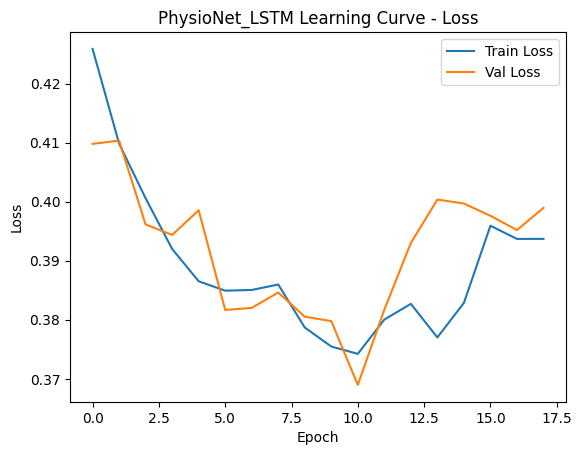

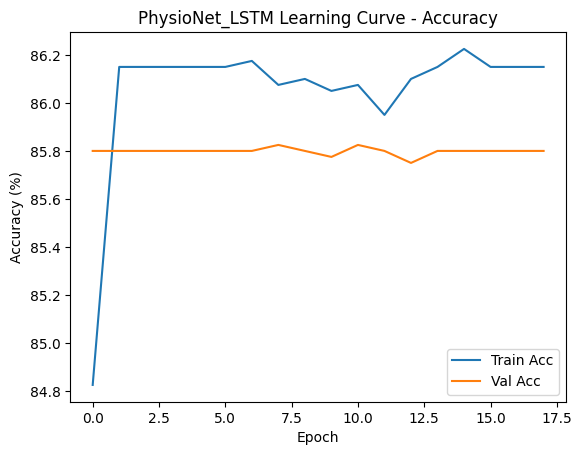

In [24]:
# Initialize and train model
model = PhysioNetLSTM(input_size=41, hidden_size=128, num_layers=2, num_classes=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Training PhysioNet LSTM...")
model, train_loss, train_acc, val_loss, val_acc = train_model(
    model, optimizer, "PhysioNet_LSTM")

In [29]:
# Function to calculate number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print model summary
print(f"\nModel Architecture:")
print(model)
total_params = count_parameters(model)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal Parameters: {total_params:,}")


Model Architecture:
PhysioNetLSTM(
  (embedding): Linear(in_features=4, out_features=128, bias=True)
  (lstm): LSTM(41, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Total Parameters: 220,545



Final Evaluation:

PhysioNet LSTM Evaluation Results:
- Precision: 1.0000
- Recall/Sensitivity: 0.0018
- Specificity: 1.0000
- F1 Score: 0.0035
- ROC AUC: 0.6932
- Average Inference Latency: 1.16 ms

Confusion Matrix:
[[3432    0]
 [ 567    1]]


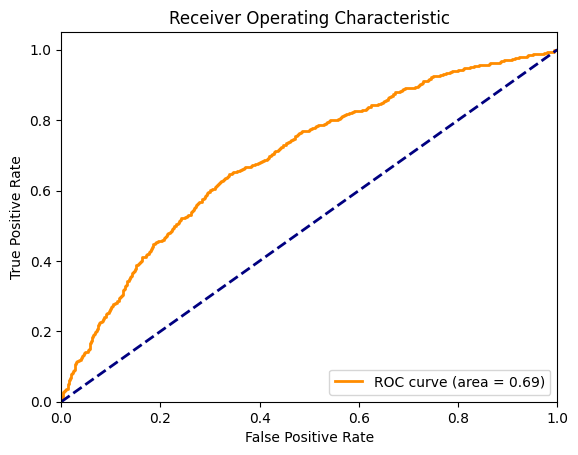

In [27]:
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
def evaluate_model(model, model_name, test_loader):
    model.eval()
    correct = 0
    total = 0
    inference_times = []
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            observed_data = batch["observed_data"].to(device)
            observed_mask = batch["observed_mask"].to(device)
            labels = batch["labels"].to(device).float()
            static_features = observed_data[:, 0, :4]

            # Measure inference time
            start_time = time.time()
            outputs = model(observed_data, static_features)
            inference_times.append((time.time() - start_time) * 1000)  # ms

            # Get predictions
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()

            # Store for metrics
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    avg_latency = np.mean(inference_times)
    accuracy = 100 * correct / total


    cm = confusion_matrix(all_labels, all_preds)
    if cm.size == 4:  # Only calculate if we have both classes
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
    else:
        specificity, sensitivity = 0, 0

    metrics = {
        'accuracy': accuracy,
        'avg_latency_ms': avg_latency,
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1_score': f1_score(all_labels, all_preds),
        'roc_auc': roc_auc_score(all_labels, all_probs),
        'specificity': specificity,
        'sensitivity': sensitivity,
        'confusion_matrix': cm.tolist()
    }

    # Print results
    print(f"\n{model_name} Evaluation Results:")
    print(f"- Precision: {metrics['precision']:.4f}")
    print(f"- Recall/Sensitivity: {metrics['recall']:.4f}")
    print(f"- Specificity: {metrics['specificity']:.4f}")
    print(f"- F1 Score: {metrics['f1_score']:.4f}")
    print(f"- ROC AUC: {metrics['roc_auc']:.4f}")
    print(f"- Average Inference Latency: {metrics['avg_latency_ms']:.2f} ms")
    print("\nConfusion Matrix:")
    print(cm)

    return metrics

# Usage example:
print("\nFinal Evaluation:")
model_metrics = evaluate_model(model, "PhysioNet LSTM", test_loader)

# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(metrics['all_labels'], metrics['all_probs'])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

